Source: http://blog.conceptnet.io/posts/2017/how-to-make-a-racist-ai-without-really-trying/

In [1]:
import re
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
from debiasing import debias
from embedding_helpers import load_embeddings
%matplotlib inline

In [2]:
TOKEN_RE = re.compile(r"\w.*?\b")

In [3]:
def load_lexicon(filename):
    """
    Load a file from Bing Liu's sentiment lexicon
    (https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html), containing
    English words in Latin-1 encoding.
    
    One file contains a list of positive words, and the other contains
    a list of negative words. The files contain comment lines starting
    with ';' and blank lines, which should be skipped.
    """
    lexicon = []
    with open(filename, encoding='latin-1') as infile:
        for line in infile:
            line = line.rstrip()
            if line and not line.startswith(';'):
                lexicon.append(line)
    return lexicon

def vecs_to_sentiment(model, vecs):
    # predict_log_proba gives the log probability for each class
    predictions = model.predict_log_proba(vecs)

    # To see an overall positive vs. negative classification in one number,
    # we take the log probability of positive sentiment minus the log
    # probability of negative sentiment.
    return predictions[:, 1] - predictions[:, 0]


def words_to_sentiment(embeddings, model, words):
    vecs = embeddings.loc[words].dropna()
    log_odds = vecs_to_sentiment(model, vecs)
    return pd.DataFrame({'sentiment': log_odds}, index=vecs.index)

def text_to_sentiment(embeddings, model, text):
    tokens = [token.casefold() for token in TOKEN_RE.findall(text)]
    sentiments = words_to_sentiment(embeddings, model, tokens)
    return sentiments['sentiment'].mean()

In [4]:
glove = load_embeddings('data/glove.6B.100d.txt')

0
100000
200000
300000


## Before Debiasing

In [5]:
pos_words = load_lexicon('data/positive-words.txt')
neg_words = load_lexicon('data/negative-words.txt')

In [6]:
pos_vectors = glove.reindex(index=pos_words).dropna()
neg_vectors = glove.reindex(index=neg_words).dropna()

In [7]:
vectors = pd.concat([pos_vectors, neg_vectors])
targets = np.array([1 for entry in pos_vectors.index] + [-1 for entry in neg_vectors.index])
labels = list(pos_vectors.index) + list(neg_vectors.index)

In [8]:
train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = \
    train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)

In [9]:
model = SGDClassifier(loss='log', random_state=0)
model.fit(train_vectors, train_targets)

SGDClassifier(loss='log', random_state=0)

In [10]:
accuracy_score(model.predict(test_vectors), test_targets)

0.8990384615384616

In [11]:
words_to_sentiment(glove, model, ['american','mexican'])

,sentiment
american,1.372401
mexican,-0.333856


In [12]:
word_sentiments = words_to_sentiment(glove, model, list(glove.index)).reset_index()

## After Debiasing

In [13]:
glove_debiased = debias(glove
                        , np.array(glove[glove.index == 'american'])[0] - np.array(glove[glove.index == 'mexican'])[0]
                        , [('american','mexican')])

Neutralizing
0
100000
200000
300000


In [14]:
pos_vectors_debiased = glove_debiased.reindex(index=pos_words).dropna()
neg_vectors_debiased = glove_debiased.reindex(index=neg_words).dropna()

In [15]:
vectors_debiased = pd.concat([pos_vectors_debiased, neg_vectors_debiased])
target_debiaseds = np.array([1 for entry in pos_vectors_debiased.index] + [-1 for entry in neg_vectors_debiased.index])
labels_debiased = list(pos_vectors_debiased.index) + list(neg_vectors_debiased.index)

In [16]:
train_vectors_debiased, test_vectors_debiased, train_targets_debiased, test_targets_debiased, train_labels_debiased, test_labels_debiased = \
    train_test_split(vectors_debiased, target_debiaseds, labels_debiased, test_size=0.1, random_state=0)

In [17]:
model_debiased = SGDClassifier(loss='log', random_state=0)
model_debiased.fit(train_vectors_debiased, train_targets_debiased)

SGDClassifier(loss='log', random_state=0)

In [18]:
accuracy_score(model_debiased.predict(test_vectors_debiased), test_targets_debiased)

0.9038461538461539

In [19]:
words_to_sentiment(glove_debiased, model_debiased, ['american','mexican'])

,sentiment
american,1.083111
mexican,1.083111


In [20]:
word_sentiments_debiased = words_to_sentiment(glove_debiased, model_debiased, list(glove_debiased.index)).reset_index()

## Compare Sentiments

In [21]:
word_sentiments.rename(columns={'index':'word'}, inplace=True)
word_sentiments_debiased.rename(columns={'index':'word', 'sentiment':'sentiment_after_debias'}, inplace=True)

In [22]:
sentiments_comparison = pd.merge(word_sentiments, word_sentiments_debiased, on='word', how='inner')

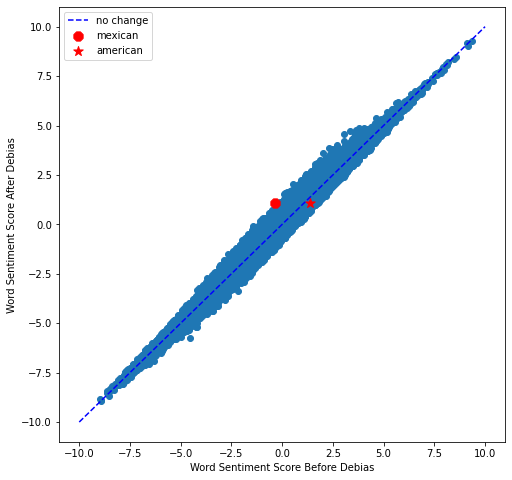

In [23]:
fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(sentiments_comparison.sentiment, sentiments_comparison.sentiment_after_debias)
ax.scatter(sentiments_comparison[sentiments_comparison.word == 'mexican'].sentiment
           , sentiments_comparison[sentiments_comparison.word == 'mexican'].sentiment_after_debias
           , color='red'
           , marker='8'
           , s=100
           , label='mexican')
ax.scatter(sentiments_comparison[sentiments_comparison.word == 'american'].sentiment
           , sentiments_comparison[sentiments_comparison.word == 'american'].sentiment_after_debias
           , color='red'
           , marker='*'
           , s=100
           , label='american')
ax.plot([-10,10],[-10,10], linestyle='--', color='blue', label='no change')
ax.set_xlabel('Word Sentiment Score Before Debias')
ax.set_ylabel('Word Sentiment Score After Debias')
_ = ax.legend()

plt.savefig('img/sentiment_scores_before_and_after.jpg')